In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.sparse import csr_matrix
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error
import itertools
from sklearn.metrics import silhouette_samples, silhouette_score
%matplotlib inline

#Import required csv files
genomeTagsFilePath = "C:\\Users\\Ben\\OneDrive\\School\\School 2020-21\\Citadel Datathon\\West Coast Datathon Materials\\movie_lense\\movie_lense\\genome-tags.csv"
genomeScoresFilePath = "C:\\Users\\Ben\\OneDrive\\School\\School 2020-21\\Citadel Datathon\\West Coast Datathon Materials\\movie_lense\\movie_lense\\genome-scores.csv"
moviesFilePath = "C:\\Users\\Ben\\OneDrive\\School\\School 2020-21\\Citadel Datathon\\West Coast Datathon Materials\\movie_lense\\movie_lense\\movies.csv"

#Load dataframes
genomeTags = pd.read_csv(genomeTagsFilePath)
genomeScores = pd.read_csv(genomeScoresFilePath)
movies = pd.read_csv(moviesFilePath)

In [25]:
############## Take given tables, convert to pivot table #################

#Create joined matrix with title, tag, and relevance
joinedDf = genomeScores.set_index('tagId').join(genomeTags.set_index('tagId'))
joinedDf = joinedDf.sort_values('movieId',axis=0).reset_index()

#Select number of movies

#Create joined matrix with title, tag, and relevance
joinedDf = genomeScores.set_index('tagId').join(genomeTags.set_index('tagId'))
joinedDf = joinedDf.sort_values('movieId',axis=0).reset_index()

#Select number of movies to analyze
numMoviesToSelect = 1000
joinedDf = joinedDf.loc[joinedDf['movieId'] <= numMoviesToSelect]
movieDf = movies.loc[movies['movieId'] <= numMoviesToSelect, 'title'] #list of movies included in the numMoviesToSelect

#Only include relevant parameters
joinedDf = joinedDf.set_index('movieId').join(movies.set_index('movieId'))
joinedDf = joinedDf[['title','tag','relevance']]

#Create pivot table to show relevance across the tags for each movie
pivotedDf = joinedDf.pivot(index='title', columns='tag', values='relevance')
movieDf.sort_values()
movieDf

0                        Toy Story (1995)
1                          Jumanji (1995)
2                 Grumpier Old Men (1995)
3                Waiting to Exhale (1995)
4      Father of the Bride Part II (1995)
                      ...                
977              Last Man Standing (1996)
978                         Caught (1996)
979                     Set It Off (1996)
980           2 Days in the Valley (1996)
981                        Curdled (1996)
Name: title, Length: 982, dtype: object

In [8]:
################# Define all helper functions ###################

#Takes in pivot table, returns pivot table will all entries replaced with Z-Score based on column mean and standard deviation
def SwitchPivotToZScore(pivotedDf):
    meanRelevance = pd.DataFrame()
    meanRelevance['mean'] = pivotedDf.mean()
    meanRelevance['std'] = pivotedDf.std()

    for column in pivotedDf:
        pivotedDf[column] = pivotedDf[column].apply(lambda val:(val-meanRelevance.loc[column,'mean'])/meanRelevance.loc[column,'std'])

    print(meanRelevance)
    return pivotedDf

#test = SwitchPivotToZScore(pivotedDf)
#test

#Takes in a pivot table, and an integer with number of top tags to return.
#Returns pivot table 
def findTopGenomeTags(pivoted, numTagsToReturn = 15):
    meanRelevance = pivoted.mean()
    meanRelevance = meanRelevance.sort_values(ascending=False)

    meanRelevanceReduced = meanRelevance.iloc[:numTagsToReturn]
    print(meanRelevanceReduced)
    
    avgRelevanceScore = meanRelevanceReduced.mean().round(5)
    print("Average Relevance Score: ", avgRelevanceScore)
    topNTags = meanRelevanceReduced.index.values.tolist()
    #print(topNTags)

    pivoted = pivoted[topNTags]
    #print(pivoted.head())  
    
    return pivoted

# Define the plotting heatmap function
def draw_movies_heatmap(pivoted, axis_labels=True):
    
    fig = plt.figure(figsize=(15,10))
    ax = plt.gca()
    
    # Draw heatmap
    heatmap = ax.imshow(pivoted,  interpolation='nearest', vmin=-3, vmax=3, aspect='auto')
    if axis_labels:
        ax.set_yticks(np.arange(pivoted.shape[0]) , minor=False)
        ax.set_xticks(np.arange(pivoted.shape[1]) , minor=False)
        ax.invert_yaxis()
        ax.xaxis.tick_top()
        labels = pivoted.columns.str[:40]
        ax.set_xticklabels(labels, minor=False)
        ax.set_yticklabels(pivoted.index, minor=False)
        plt.setp(ax.get_xticklabels(), rotation=90)
    else:
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    
    ax.grid(False)
    ax.set_ylabel('User id')
# Separate heatmap from color bar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="1%", pad=0.05)
# Color bar
    cbar = fig.colorbar(heatmap, ticks=[3, 2, 1, 0, -1, 2, -3], cax=cax)
    cbar.ax.set_yticklabels(['3','2','1','0','-1','-2','-3'])
plt.show()


# Print the heatmap
#draw_movies_heatmap(pivoted.iloc[:10,:30])
    
#findTopGenomeTags(pivotedDf.iloc[:50,:50])

In [34]:
############# Train K means model, output which movies are in which clusters #####################

#Get list of all genome tags
tagList = genomeTags['tag'].tolist() 

#Get sorted list of all movies within numMoviesToSelect
movieListDf = pd.DataFrame()
moviesList = joinedDf['title'].unique()
moviesList.sort()
movieListDf['title'] = moviesList

#Train Kmeans algorithm
X = pivotedDf[tagList].values
kmeans = KMeans(n_clusters=80)
predictions = kmeans.fit_predict(X)

#Print out predictions, this tells which cluster each movie is in
clustered = pd.concat([movieListDf, pd.DataFrame({'group':predictions})], axis=1)
clustered

,title,group
0,'Til There Was You (1997),3
1,1-900 (06) (1994),66
2,2 Days in the Valley (1996),4
3,2001: A Space Odyssey (1968),14
4,"301, 302 (301/302) (1995)",66
...,...,...
902,"Wooden Man's Bride, The (Yan shen) (1994)",46
903,"World of Apu, The (Apur Sansar) (1959)",63
904,Wyatt Earp (1994),41
905,"Yes, Madam (a.k.a. Police Assassins) (a.k.a. I...",50


tag
based on a book      0.852625
adapted from:book    0.827875
based on book        0.779625
adaptation           0.724771
original             0.721604
childhood            0.701188
books                0.679562
family               0.618167
children             0.583979
book                 0.567562
fantasy world        0.560979
adventure            0.527583
book was better      0.497792
story                0.486521
mentor               0.473500
dtype: float64
Average Relevance Score:  0.64022


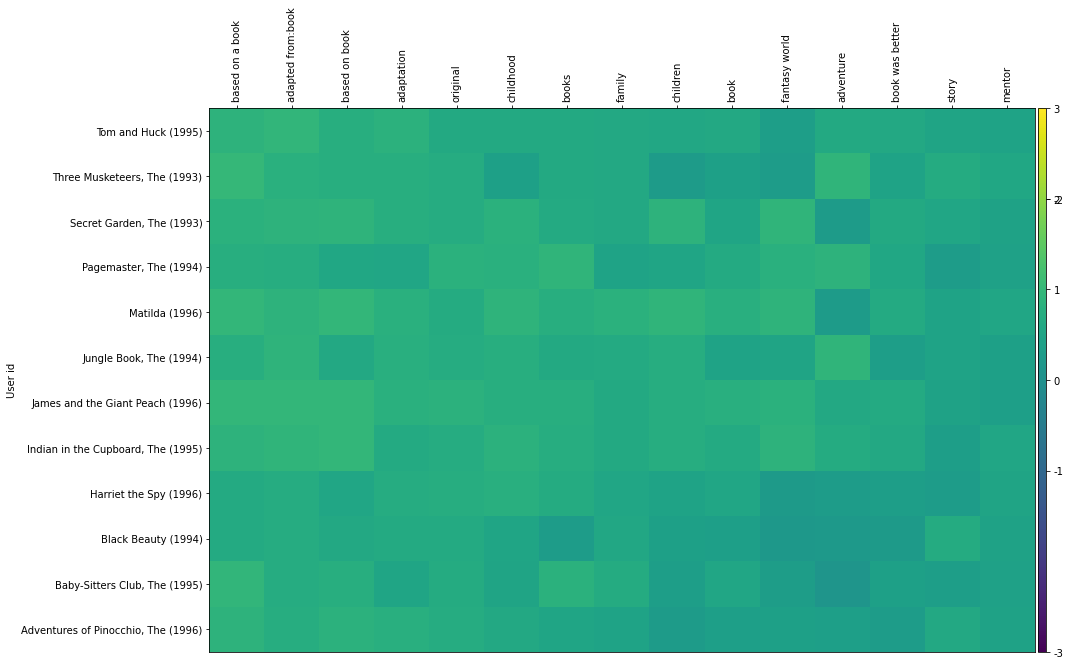

In [37]:
############# Pick a cluster, analyze its heat map of relevance scores ###############
#Ideally, all movies in each cluster should score similarly (ie color of heatmap is very similar across columns)

#Pick a cluster number to analyze
clusterNum = 6
cluster = clustered.loc[clustered['group'] == clusterNum]['title'].tolist()
#print(cluster)

#Draw a heatmap for the selected cluster
reduced_pivot = pivotedDf.loc[pivotedDf.index.isin(cluster)]
reduced_pivot = findTopGenomeTags(reduced_pivot) #only show the top associated tags
draw_movies_heatmap(reduced_pivot)

tag
original           0.763110
mentor             0.512120
storytelling       0.502090
great ending       0.492495
catastrophe        0.486815
dialogue           0.468480
good               0.451775
runaway            0.433475
good soundtrack    0.432720
story              0.427310
vengeance          0.422415
great              0.417260
chase              0.417105
brutality          0.409880
weird              0.399875
dtype: float64
[&#39;original&#39;, &#39;mentor&#39;, &#39;storytelling&#39;, &#39;great ending&#39;, &#39;catastrophe&#39;, &#39;dialogue&#39;, &#39;good&#39;, &#39;runaway&#39;, &#39;good soundtrack&#39;, &#39;story&#39;, &#39;vengeance&#39;, &#39;great&#39;, &#39;chase&#39;, &#39;brutality&#39;, &#39;weird&#39;]


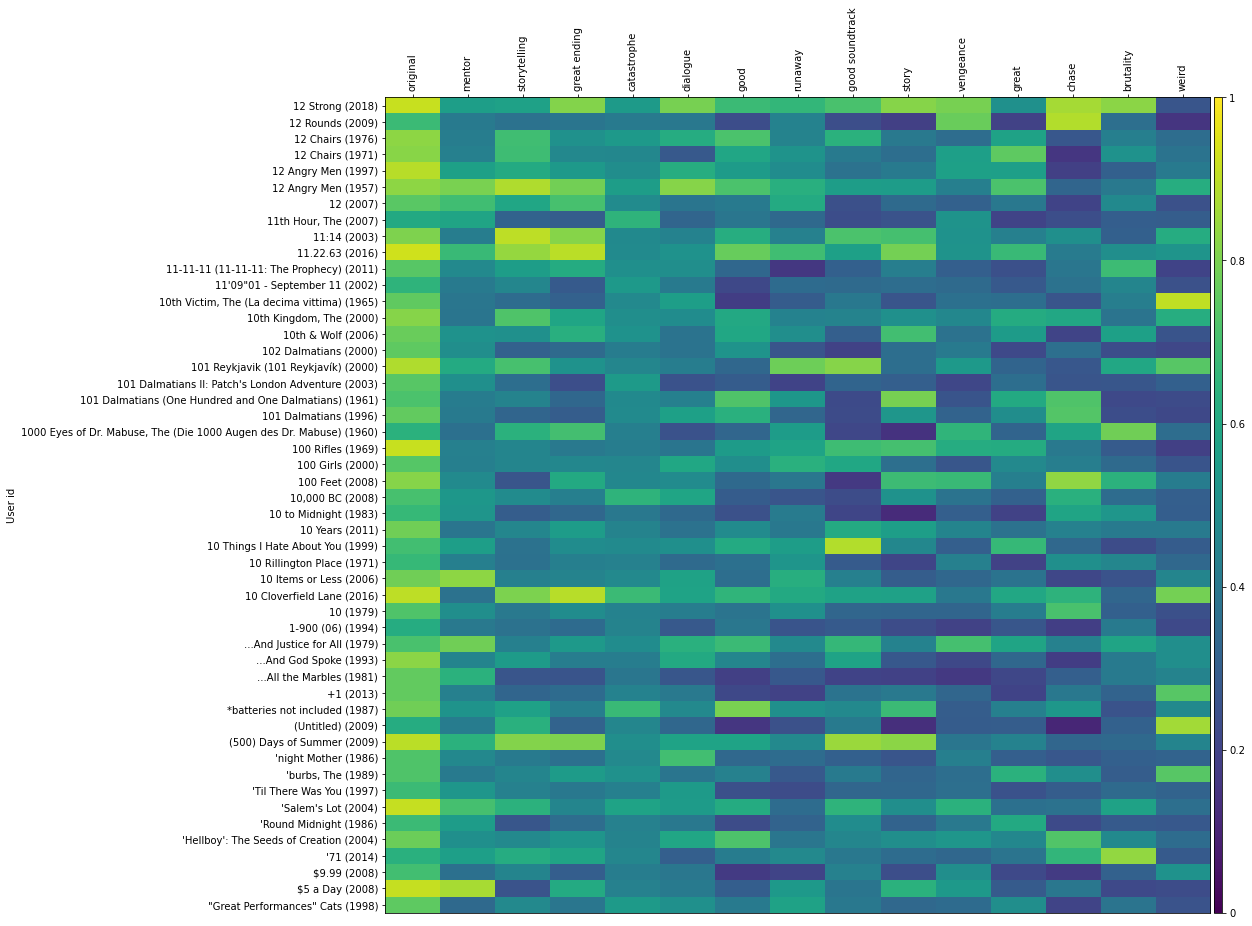

In [169]:
#Random testing

reduced_pivot = findTopGenomeTags(pivoted.iloc[:50])
draw_movies_heatmap(reduced_pivot)